In [1]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import json

In [27]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_' + string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_' + string])
    plt.show()

In [3]:
DATA_IN_PATH = './data-in/'
DATA_OUT_PATH = './data-out/'

TRAIN_INPUT_DATA = 'nsmc_train_input.npy'
TRAIN_LABEL_DATA = 'nsmc_train_label.npy'

DATA_CONFIGS = 'nsmc_data_configs.json'

In [4]:
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

In [5]:
train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [6]:
model_name = 'cnn_classifier_kr'
batch_size = 512
num_epochs = 10
valid_split = 0.1
max_len = train_input.shape[1]

kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_size': 128,
        'num_filters': 100,
        'dropout_rate': 0.5,
        'hidden_dimension': 250,
        'output_dimension': 1}

In [17]:
class CNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(CNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size']+1,
                                         output_dim=kargs['embedding_size'])
        self.conv_list = [layers.Conv1D(filters=kargs['num_filters'],
                                    kernel_size=kernel_size,
                                    padding= 'valid',
                                    activation = 'relu',
        kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
                       for kernel_size in [3, 4, 5]]
        self.pooling = layers.GlobalMaxPooling1D()
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['hidden_dimension'],
                                activation = 'relu',
            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                                activation = 'sigmoid',
            kernel_constraint=tf.keras.constraints.MaxNorm(max_value=3.))  
        
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = tf.concat([self.pooling(conv(x)) for conv in self.conv_list],
                     axis=-1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x

#### 가중치 값이 너무 커지면 학습이 부적합

In [18]:
model = CNNClassifier(**kargs)
model.compile(loss='binary_crossentropy', optimizer='adam',
             metrics=['accuracy'])

In [19]:
early_stop = EarlyStopping(monitor='val_accuracy',
                          min_delta=0.0001, # 오차 기준 최소 증가폭
                          patience=2) # 2번까지 증가하지 않으면 멈춰라.
                                      # min_delta = threshold(문지방)

#h5 파라메터 값만 저장함. 모델 layer 가 있어야 사용가능
checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5' 
checkpoint_dir = os.path.dirname(checkpoint_path)

if not os.path.exists(checkpoint_dir):
    os.mkdir(checkpoint_dir)
    
checkpoint = ModelCheckpoint(checkpoint_path,
                            monitor='val_accuracy',
                            verbose=1, save_best_only=True,
                            save_weights_only=True)
    

In [20]:
history = model.fit(train_input, train_label, batch_size=batch_size,
                   epochs=num_epochs, validation_split=valid_split,
                   callbacks=[early_stop, checkpoint])

Epoch 1/10
264/264 [==============================] - ETA: 0s - loss: 0.4583 - accuracy: 0.7759
Epoch 00001: val_accuracy improved from -inf to 0.81960, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 21s 79ms/step - loss: 0.4583 - accuracy: 0.7759 - val_loss: 0.3951 - val_accuracy: 0.8196
Epoch 2/10
264/264 [==============================] - ETA: 0s - loss: 0.3521 - accuracy: 0.8451
Epoch 00002: val_accuracy improved from 0.81960 to 0.82947, saving model to ./data-out/cnn_classifier_kr\weights.h5
264/264 [==============================] - 21s 79ms/step - loss: 0.3521 - accuracy: 0.8451 - val_loss: 0.3846 - val_accuracy: 0.8295
Epoch 3/10
264/264 [==============================] - ETA: 0s - loss: 0.3019 - accuracy: 0.8724
Epoch 00003: val_accuracy did not improve from 0.82947
264/264 [==============================] - 21s 79ms/step - loss: 0.3019 - accuracy: 0.8724 - val_loss: 0.3931 - val_accuracy: 0.8245
Epoch 4/10
264/264 [=========

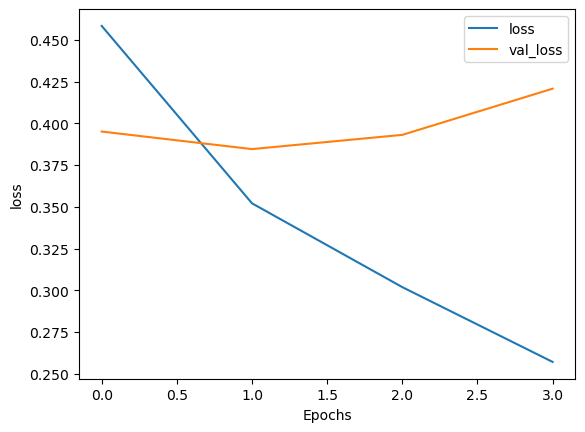

In [28]:
plot_graphs(history, 'loss')
plt.show()

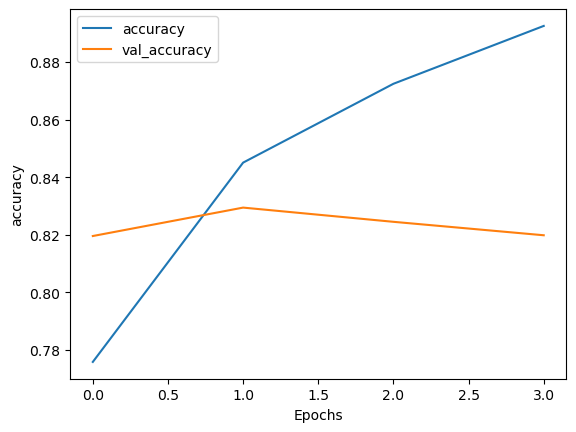

In [29]:
plot_graphs(history, 'accuracy')

In [36]:
TEST_INPUT_DATA = 'nsmc_test_input.npy'
TEST_LABEL_DATA = 'nsmc_test_label.npy'
SAVE_FILE_NAME = 'weights.h5'

test_input = np.load(open(DATA_IN_PATH + TEST_INPUT_DATA, 'rb'))
test_label = np.load(open(DATA_IN_PATH + TEST_LABEL_DATA, 'rb'))

In [37]:
model.load_weights(os.path.join(DATA_OUT_PATH, model_name, SAVE_FILE_NAME))

In [38]:
model.evaluate(test_input, test_label)

1563/1563 [==============================] - 2s 1ms/step - loss: 0.3876 - accuracy: 0.8270


[0.3875962495803833, 0.827019989490509]